# Computing MVBS based on time, looping through all Sv files

For calculating MVBS based on time, when the desired temporal resolution is fine (~seconds), the xarray resample operation can be really slow. It is most likely a balance between the number of pings in each file and the number of pings that go into each temporal interval. 

In this notebook we loop through all Sv files to calculate MVBS based on 200-sec intervals. This operation is not possible (extremely slow) when multiple files are involved.

In [1]:
import os
import glob
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from dask.distributed import Client
client = Client()

In [3]:
from dask.distributed import performance_report

## Load multiple data files

In [4]:
nc_path = '/Users/wu-jung/code_git/ooi_sonar/zplsc_data_2015fall/nc_raw/'
nc_files = sorted(glob.glob(nc_path+'*.nc'))   # sort to order by date in filename
nc_Sv_path = '/Users/wu-jung/code_git/ooi_sonar/zplsc_data_2015fall/nc_raw/'
nc_Sv_files = sorted(glob.glob(nc_Sv_path+'*_Sv.nc'))   # sort to order by date in filename

## Set MVBS params and output file path and filename

In [5]:
MVBS_range_bin_size = 5  # [m]

In [6]:
save_path = '/Users/wu-jung/code_git/ooi_sonar/zplsc_data_2015fall/nc_MVBS/'
MVBS_fname_from_Sv_time_prefix = (f'20150817-20151017_MVBS_time_from_Sv'
                                  f'_rangeBin{MVBS_range_bin_size}_')

In [7]:
MVBS_fname_from_Sv_time_prefix

'20150817-20151017_MVBS_time_from_Sv_rangeBin5_'

## Get various variables for MVBS calculation

Calculating sample thickness, which will be used to determine the number of range bins used for each MVBS tile.

In [8]:
with xr.open_dataset(nc_files[0], group="Beam") as ds_beam:
    with xr.open_dataset(nc_files[0], group="Environment") as ds_env:
        sample_thickness = ds_env.sound_speed_indicative * ds_beam.sample_interval / 2  # sample thickness
sample_thickness

<xarray.DataArray (frequency: 3)>
array([0.19121777, 0.19121777, 0.19121777], dtype=float32)
Coordinates:
  * frequency  (frequency) float32 120000.0 38000.0 200000.0

Set range bin (depth) and ping number sizes for each MVBS tile.

Adjust tile range bin size so that it is an integer multiple of the sample thickness.

In [9]:
# Adjust noise_est_range_bin_size because range_bin_size may be an inconvenient value
with xr.open_mfdataset(nc_Sv_files[:5], combine='by_coords') as ds:
    r_data_sz = ds['range_bin'].size   # dimension of range_bin in data file
    num_r_per_tile = (np.round(MVBS_range_bin_size / sample_thickness).
                      astype(int)).values.max()  # num of range_bin per tile
    MVBS_range_bin_size = (num_r_per_tile * sample_thickness).values

    num_tile_range_bin = np.ceil(r_data_sz / num_r_per_tile).astype(int)

    print(f'There are {num_r_per_tile} range bins in each MVBS tile.')
    print(f'There are a total of {num_tile_range_bin} range_bin bins for each Sv tile.')

There are 26 range bins in each MVBS tile.
There are a total of 41 range_bin bins for each Sv tile.


Below are the bin edges we will use to group values along the `range_bin` dimension:

In [10]:
r_tile_bin_edge = np.arange(num_tile_range_bin+1) * num_r_per_tile - 1
r_tile_bin_edge

array([  -1,   25,   51,   77,  103,  129,  155,  181,  207,  233,  259,
        285,  311,  337,  363,  389,  415,  441,  467,  493,  519,  545,
        571,  597,  623,  649,  675,  701,  727,  753,  779,  805,  831,
        857,  883,  909,  935,  961,  987, 1013, 1039, 1065])

## MVBS computation

In [11]:
for cnt,file in enumerate(nc_Sv_files):
    with xr.open_dataset(file) as ds:
        ds_linear = 10**(ds/10)  # convert to linear domain
        ds_linear_time = ds_linear.resample(ping_time='200S',skipna=True).\
                         mean().dropna(dim='ping_time')
        MVBS_time = 10*np.log10(  # convert back to log domain
            ds_linear_time.groupby_bins('range_bin',r_tile_bin_edge).mean())
        MVBS_time = MVBS_time.rename({'Sv': 'MVBS'})
        MVBS_time['range'] = ('range_bin_bins',
                              np.arange(MVBS_time['range_bin_bins'].size)*np.unique(MVBS_range_bin_size))
        MVBS_time.coords['range_bin'] = ('range_bin_bins',
                                         np.arange(MVBS_time['range_bin_bins'].size))
        MVBS_time = MVBS_time.swap_dims({'range_bin_bins': 'range_bin'}).\
                              drop_vars('range_bin_bins')
        MVBS_time.to_netcdf(os.path.join(save_path,MVBS_fname_from_Sv_time_prefix + '%02d.nc'%cnt))

distributed.utils - ERROR - 'start'
Traceback (most recent call last):
  File "//miniconda3/envs/ooi_sonar/lib/python3.7/site-packages/distributed/utils.py", line 663, in log_errors
    yield
  File "//miniconda3/envs/ooi_sonar/lib/python3.7/site-packages/distributed/dashboard/components/shared.py", line 312, in update
    ts = metadata["keys"][self.key]
KeyError: 'start'
tornado.application - ERROR - Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <zmq.eventloop.ioloop.ZMQIOLoop object at 0x11eb6e278>>, <Future finished exception=KeyError('start')>)
Traceback (most recent call last):
  File "//miniconda3/envs/ooi_sonar/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "//miniconda3/envs/ooi_sonar/lib/python3.7/site-packages/tornado/ioloop.py", line 767, in _discard_future_result
    future.result()
  File "//miniconda3/envs/ooi_sonar/lib/python3.7/site-packages/tornado/gen.py", line 748, in run

## Open all files to merge into 1 file

In [18]:
MVBS_files = sorted(glob.glob(save_path+MVBS_fname_from_Sv_time_prefix+'*.nc'))

In [21]:
ds_mvbs_all = xr.open_mfdataset(MVBS_files, combine='by_coords')
ds_mvbs_all

<xarray.Dataset>
Dimensions:    (frequency: 3, ping_time: 8929, range_bin: 41)
Coordinates:
  * frequency  (frequency) float32 120000.0 38000.0 200000.0
  * range_bin  (range_bin) int64 0 1 2 3 4 5 6 7 8 ... 33 34 35 36 37 38 39 40
  * ping_time  (ping_time) datetime64[ns] 2015-08-17 ... 2015-10-17T23:16:40
Data variables:
    MVBS       (range_bin, ping_time, frequency) float64 dask.array<chunksize=(41, 144, 3), meta=np.ndarray>
    range      (ping_time, range_bin) float64 dask.array<chunksize=(144, 41), meta=np.ndarray>

In [23]:
ds_mvbs_all.to_netcdf(os.path.join(save_path,MVBS_fname_from_Sv_time_prefix+'all.nc'))

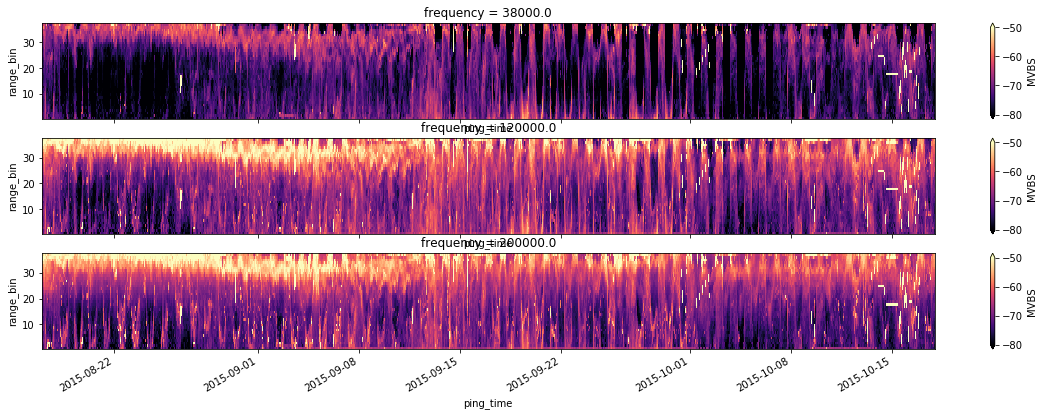

In [30]:
fig, ax = plt.subplots(3,1,figsize=(20,6),sharex=True)
ds_mvbs_all['MVBS'].sel(frequency=38000).isel(range_bin=slice(1,38)).\
    plot(ax=ax[0], x='ping_time',cmap='magma',vmin=-80,vmax=-50)
ds_mvbs_all['MVBS'].sel(frequency=120000).isel(range_bin=slice(1,38)).\
    plot(ax=ax[1], x='ping_time',cmap='magma',vmin=-80,vmax=-50)
ds_mvbs_all['MVBS'].sel(frequency=200000).isel(range_bin=slice(1,38)).\
    plot(ax=ax[2], x='ping_time',cmap='magma',vmin=-80,vmax=-50)
plt.show()
fig.savefig(os.path.join(save_path,MVBS_fname_from_Sv_time_prefix+'all.png'),
            dpi=150,bbox_inches = 'tight', pad_inches = 0)            